In [32]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
import pandas as pd
from typing import List
import torchvision

import torch.nn.functional as F
import pytorch_lightning as pl

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.data.transforms import TransformRefactored
from symlie.model.networks.mlp import CombiMLP
from symlie.model.learner import CombiLearner, TransformationBlock

from symlie.run import parse_options, main, process_args


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
args = parse_options(notebook=True)

args.noise_std = 1.
args.grid_size = (1, 7)
args.eps_mult = [0.0, 0.0, 1.0, 0.0]
args.net = 'TrainP'
args.data_dir = '../data/sine1d'
args.y_low = 1
args.y_high = 3
args.noise_std = 0.5

args.do_return = True
args.logger = None

args.n_train = 100

process_args(args)

# Training
_, _, datamodule = main(args)

n_epochs = 50
size = np.prod(args.grid_size)

Seed set to 42


Running without logging


In [34]:
trainloader = datamodule.train_dataloader()

In [35]:
transform = TransformationBlock(args.transform_kwargs)

In [41]:

seed, method = 41, 'mlp'

net = CombiMLP(
    implicit_layer_dims=[[49, 49, 49], [0]],
    vanilla_layer_dims=[7, 7, 1],
    bias = False
)



# Define the loss function and optimizer
criterion_y     = nn.MSELoss()
criterion_o     = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

losses_y = []
losses_o = []

# Run the training loop
for epoch in tqdm(range(0, n_epochs), desc = f'seed={seed}, method={method}'):
    
    current_loss_y = 0.0
    current_loss_o = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        
        # Zero the gradients
        optimizer.zero_grad()

        # Get inputs
        x, y, _ = data
        batch_size = x.size(0)
        
        
        weight = net.layers[0](net.weights[0])
        # weight = net.weights_out[0].detach()
        o_a_prime, o_b_prime = transform.forward_transformation(batch_size, (1, 7), weight)

        y_pred = net(x)

        # Compute loss
        loss_o = criterion_o(o_a_prime, o_b_prime)

        # Compute loss
        loss_y = criterion_y(y_pred, y)

        loss = loss_o + loss_y

        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss_y += loss_o.item()
        current_loss_o += loss_y.item()
    current_loss_y = current_loss_y / len(trainloader)
    current_loss_o = current_loss_o / len(trainloader)
    losses_y.append(current_loss_y)
    losses_o.append(current_loss_o)



seed=41, method=mlp: 100%|██████████| 50/50 [00:00<00:00, 175.36it/s]


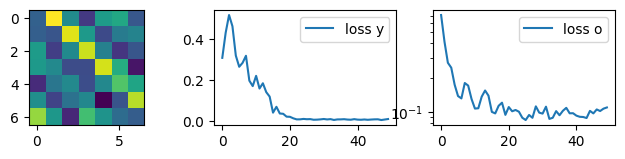

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(8,1.5))

weight = torch.rand(size, size)
# weight = net.mlp1(weight, net.layers1)
# weight = net.layers1(net.weight1)
# weight = net.layers[0](net.weight1)
weight = net.layers[0](weight)
# weight = net.layers[0](net.weights[0])

ax = axs[0]
ax.imshow( weight.detach().cpu().numpy() )

ax = axs[1]
ax.plot(losses_y, label='loss y')
ax.legend()

ax = axs[2]
ax.plot(losses_o, label='loss o')
ax.set_yscale('log')
ax.legend()

plt.show()



In [43]:
losses_y

[0.308432753596987,
 0.43115482160023283,
 0.517965304000037,
 0.4631184105362211,
 0.3194697754723685,
 0.2647074908018112,
 0.28397143738610403,
 0.3185134742941175,
 0.1967474573424884,
 0.17011981989656175,
 0.22029576769896916,
 0.15828812548092433,
 0.1840138084122113,
 0.14045658920492446,
 0.11884371510573796,
 0.04025911859103611,
 0.068837079086474,
 0.03608247531311853,
 0.03462974700544562,
 0.020655167688216482,
 0.019898937482919012,
 0.012383833527565002,
 0.007254715875855514,
 0.00745908057849322,
 0.009540990926325321,
 0.008075149530278785,
 0.008622301409819297,
 0.005501676749970231,
 0.006024455784686974,
 0.0072744375626955715,
 0.009163388250661748,
 0.006978744507900306,
 0.00854543929121324,
 0.0044624835385807925,
 0.007090546589876924,
 0.007304957735219172,
 0.00820257787459663,
 0.006377390785408872,
 0.005635096558502742,
 0.008419183482016836,
 0.0060532681777008945,
 0.005463112810892718,
 0.00677836559978979,
 0.005288645292499236,
 0.00648577298436846